In [1]:
import re
import os
import unicodedata
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
file = ["../data/곡성_사투리정리.csv",
    "../data/부당거래_사투리라벨1.csv",
    "../data/신세계_사투리.csv",
    "../data/우리형_사투리정리.csv",
    "../data/은밀하게_위대하게_사투리정리.csv",
    "../data/택시운전사_사투리정리.csv",
	"../data/친구_사투리정리.csv",
	"../data/꽃피는봄이오면_사투리정리.csv"
]

In [3]:
# 공통 열만 골라 병합
data = pd.concat([
    pd.read_csv(path, usecols=["Speaker", "CleanLine", "Dialect"]) for path in file
], ignore_index=True)

In [4]:
print(data.head())

                       Speaker  \
0                       오프닝 자막   
1    띄엄띄엄 앉은 몇 명의 남자들이 낚시 중이다.   
2       인상을 찌푸린 노인의 시선을 따라가 보면   
3  닭도리탕인디 들어보시요. 쐬주도 한 잔 받으시고.   
4                           여자   

                                           CleanLine Dialect  
0                            자막 그들은 놀라고 무서움에 사로잡혀서,,     표준어  
1  그들 중 한 노인이 지렁이를 꿰며 저편을 응시하고 있다., 심기가 좋아 보이질 않는...     표준어  
2        짝을 맞춰 놀러 온 중년의 남녀들이 커다란 양은솥에 뭔가를 끓여 먹고 있다.,     전라도  
3  그릇을 노인의 앞에 내려놓은 여자가 겨드랑이에 끼고 온 소주를 종이컵에 따른다., ...     표준어  
4           술을 받아 든 노인이 묘한 눈길로 여자를 보더니 음식을 빤히 쳐다본다.,     전라도  


In [5]:
data

,Speaker,CleanLine,Dialect
0,오프닝 자막,"자막 그들은 놀라고 무서움에 사로잡혀서,,",표준어
1,띄엄띄엄 앉은 몇 명의 남자들이 낚시 중이다.,"그들 중 한 노인이 지렁이를 꿰며 저편을 응시하고 있다., 심기가 좋아 보이질 않는...",표준어
2,인상을 찌푸린 노인의 시선을 따라가 보면,"짝을 맞춰 놀러 온 중년의 남녀들이 커다란 양은솥에 뭔가를 끓여 먹고 있다.,",전라도
3,닭도리탕인디 들어보시요. 쐬주도 한 잔 받으시고.,"그릇을 노인의 앞에 내려놓은 여자가 겨드랑이에 끼고 온 소주를 종이컵에 따른다., ...",표준어
4,여자,"술을 받아 든 노인이 묘한 눈길로 여자를 보더니 음식을 빤히 쳐다본다.,",전라도
...,...,...,...
5253,연희,술은 갑자기 왜…?,전라도
5254,현우,왜는 뭐가 왜야…. 그냥… 봄이잖아….,전라도
5255,연희,…….,전라도
5256,현우,트럼펫이나 색소폰 같은 거는 안 가르치니?,전라도


In [6]:
# 1. 텍스트와 라벨 추출
data = data.dropna(subset=["CleanLine", "Dialect"])
texts = data["CleanLine"].astype(str).tolist()
labels = data["Dialect"].astype(str).tolist()  # 문자열로 변환

In [7]:
# 2. 라벨 인코딩 (ex: 경상도 → 0, 전라도 → 1 ...)
label_mapping = {label: idx for idx, label in enumerate(sorted(set(labels)))}
label_ids = [label_mapping[label] for label in labels]

In [8]:
# 3. 텍스트 정제 + 토크나이징
def tokenize(text):
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip().split()

tokenized_texts = [tokenize(text) for text in texts]

In [9]:
# 4. 단어 인덱스 만들기 (빈도수 기준 top N)
vocab = Counter([word for sent in tokenized_texts for word in sent])
vocab = {word: idx+2 for idx, (word, _) in enumerate(vocab.most_common(10000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

In [159]:
import pickle

# vocab 저장
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print("✅ vocab.pkl로 저장 완료!")

✅ vocab.pkl로 저장 완료!


In [10]:
# 5. 시퀀스 숫자 인코딩
def encode_sentence(tokens, vocab, max_len=40):
    tokens = tokens[:max_len]
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    return ids + [vocab["<PAD>"]] * (max_len - len(ids))

encoded_sequences = [encode_sentence(sent, vocab) for sent in tokenized_texts]


In [11]:
# 6. 텐서 변환
X_tensor = torch.tensor(encoded_sequences, dtype=torch.long)
y_tensor = torch.tensor(label_ids, dtype=torch.long)

In [12]:
# 클래스별 개수 확인
from collections import Counter
print(Counter(label_ids))  

Counter({4: 2395, 0: 1695, 3: 1082, 1: 69, 2: 1})


In [13]:
# pip install koreanize-matplotlib

In [14]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [15]:
# 방언 라벨 수 카운트
label_counts_dict = data["Dialect"].value_counts()

# 변수 정의
label_names = label_counts_dict.index.tolist()
label_counts = label_counts_dict.values.tolist()

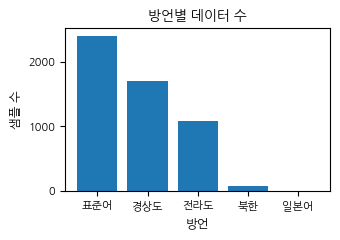

In [16]:
# 그래프 크기 조절 (작게)
plt.figure(figsize=(3.5, 2.5))  # 기본보다 작게 설정

# 2️그래프 그리기
plt.bar(label_names, label_counts)
plt.title("방언별 데이터 수", fontsize=10)
plt.xlabel("방언", fontsize=9)
plt.ylabel("샘플 수", fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 저장 (크기 & 투명도 유지)
plt.tight_layout()
plt.savefig("dialect_graph.png", dpi=150, transparent=True)
plt.show()

In [17]:
from torch.utils.data import WeightedRandomSampler

In [18]:
# 클래스별 가중치 계산
class_sample_count = Counter(y_tensor.numpy())
weights = 1. / np.array([class_sample_count[i] for i in y_tensor.numpy()])
sampler = WeightedRandomSampler(weights, len(weights))

In [19]:
from collections import Counter

# 클래스별 개수 확인
label_counts = Counter(label_ids)
valid_indices = [i for i, label in enumerate(label_ids) if label_counts[label] >= 2]

# 필터링
X_tensor = X_tensor[valid_indices]
y_tensor = y_tensor[valid_indices]

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [21]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [22]:
print("전처리 및 데이터 준비 완료")
print(f"클래스 목록: {label_mapping}")
print(f"훈련 데이터 크기: {X_train.shape}, 검증: {X_val.shape}, 테스트: {X_test.shape}")

전처리 및 데이터 준비 완료
클래스 목록: {'경상도': 0, '북한': 1, '일본어': 2, '전라도': 3, '표준어': 4}
훈련 데이터 크기: torch.Size([3668, 40]), 검증: torch.Size([786, 40]), 테스트: torch.Size([787, 40])


In [23]:
class DNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(DNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * 40, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [24]:
# 하이퍼파라미터 및 초기화
embedding_dim = 128
hidden_dim = 64
num_classes = len(set(label_ids))
vocab_size = len(vocab)

device = torch.device("cpu")  # NCCL 에러 회피를 위한 CPU 강제 설정
model = DNNClassifier(vocab_size, embedding_dim, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# DataLoader 준비
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

In [26]:
patience = 6  # 연속으로 val 손실이 좋아지지 않는 허용 횟수
trigger_times = 0
best_val_loss = float('inf')
best_model_path = "best_model_dialect.pt"

epochs = 30
for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증
    model.eval()
    total_val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"Epoch {epoch}/{epochs} )"
          f"Train Loss: {total_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {total_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 가장 좋은 검증 손실인 경우 저장
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 모델 저장됨: {best_model_path} (Val Loss: {best_val_loss:.4f})")
        trigger_times = 0  # 초기화
    else:
        trigger_times += 1
        print(f"⚠️ Early Stopping Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("🛑 손실률이 연속으로 개선되지 않아 조기 종료합니다.")
            break


Epoch 1/30 )Train Loss: 65.7895, Train Acc: 0.5507 | Val Loss: 12.7571, Val Acc: 0.6221
✅ 모델 저장됨: best_model_dialect.pt (Val Loss: 12.7571)
Epoch 2/30 )Train Loss: 38.4933, Train Acc: 0.7576 | Val Loss: 12.0265, Val Acc: 0.6145
✅ 모델 저장됨: best_model_dialect.pt (Val Loss: 12.0265)
Epoch 3/30 )Train Loss: 24.6771, Train Acc: 0.8730 | Val Loss: 12.0243, Val Acc: 0.6323
✅ 모델 저장됨: best_model_dialect.pt (Val Loss: 12.0243)
Epoch 4/30 )Train Loss: 15.0326, Train Acc: 0.9338 | Val Loss: 12.8438, Val Acc: 0.6590
⚠️ Early Stopping Trigger: 1/6
Epoch 5/30 )Train Loss: 9.2615, Train Acc: 0.9659 | Val Loss: 13.1879, Val Acc: 0.6718
⚠️ Early Stopping Trigger: 2/6
Epoch 6/30 )Train Loss: 6.0469, Train Acc: 0.9812 | Val Loss: 14.3017, Val Acc: 0.6603
⚠️ Early Stopping Trigger: 3/6
Epoch 7/30 )Train Loss: 4.0305, Train Acc: 0.9885 | Val Loss: 15.6766, Val Acc: 0.6590
⚠️ Early Stopping Trigger: 4/6
Epoch 8/30 )Train Loss: 2.9050, Train Acc: 0.9918 | Val Loss: 16.2921, Val Acc: 0.6387
⚠️ Early Stopping Tr

In [102]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [103]:
# 에폭 데이터 (1~9까지)
epochs = list(range(1, 10))

In [104]:
# 로그에서 추출한 값
train_loss = [65.9284, 38.5299, 24.6255, 14.9832, 9.1499, 5.8799, 3.9947, 3.0951, 2.2754]
val_loss   = [12.4930, 11.1654, 10.8486, 11.6641, 12.5907, 13.5049, 14.4889, 15.1699, 16.3668]
train_acc  = [0.5450, 0.7653, 0.8746, 0.9384, 0.9643, 0.9828, 0.9891, 0.9899, 0.9929]
val_acc    = [0.6145, 0.6603, 0.6819, 0.6641, 0.6679, 0.6692, 0.6756, 0.6756, 0.6616]

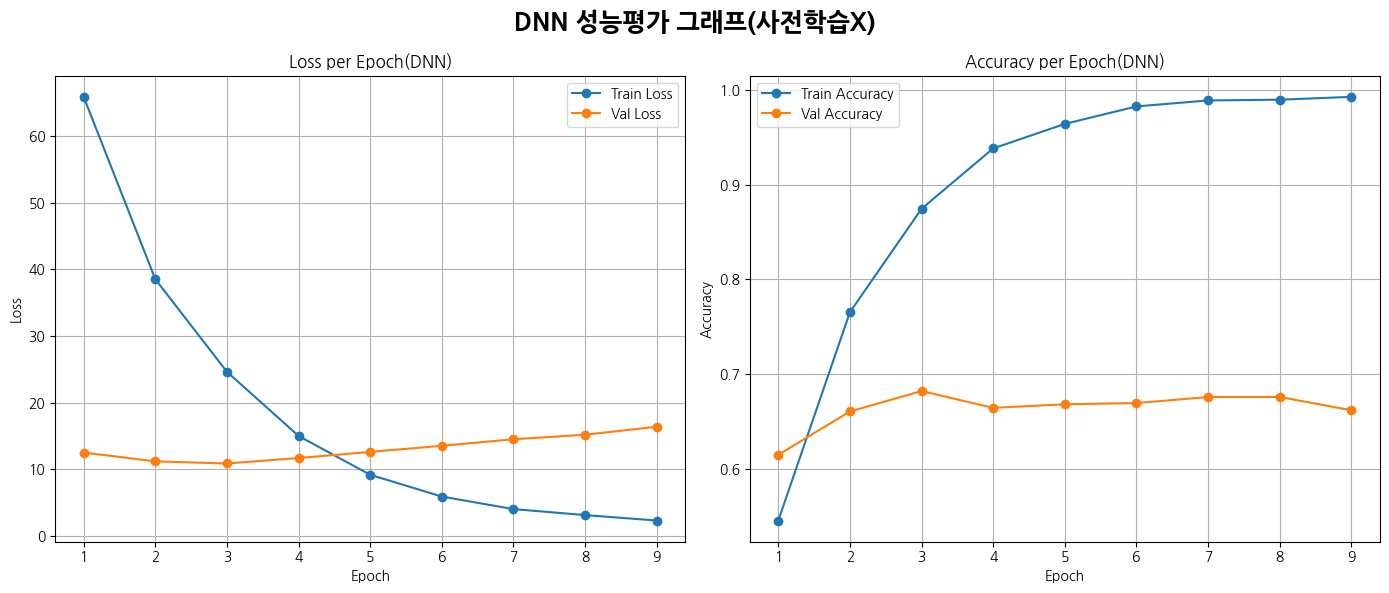

In [105]:
# 그래프 그리기
plt.figure(figsize=(14, 6))

# 전체 제목 
plt.suptitle('DNN 성능평가 그래프(사전학습X)', fontsize=18, fontweight='bold')

# 손실 함수 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch(DNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch(DNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("DNN_graph.png", dpi=150, transparent=True)
plt.show()

In [31]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        output, hidden = self.rnn(embedded)  # hidden: (num_layers, batch, hidden_dim)
        final_feature = hidden[-1]  # 마지막 레이어의 hidden state
        return self.fc(final_feature)

In [32]:
# 하이퍼파라미터 및 초기화
embedding_dim = 128
hidden_dim = 64
num_classes = len(set(label_ids))
vocab_size = len(vocab)

device = torch.device("cpu")  # NCCL 에러 회피를 위한 CPU 강제 설정
model = RNNClassifier(vocab_size, embedding_dim, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
# DataLoader 준비
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

In [34]:
patience = 6  # 연속으로 val 손실이 좋아지지 않는 허용 횟수
trigger_times = 0
best_val_loss = float('inf')
best_model_path = "RNN_best_model_dialect.pt"
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증
    model.eval()
    total_val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"Epoch {epoch}/{epochs} )"
          f"Train Loss: {total_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {total_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 가장 좋은 검증 손실인 경우 저장
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 모델 저장됨: {best_model_path} (Val Loss: {best_val_loss:.4f})")
        trigger_times = 0  # 초기화
    else:
        trigger_times += 1
        print(f"⚠️ Early Stopping Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("🛑 손실률이 연속으로 개선되지 않아 조기 종료합니다.")
            break


Epoch 1/30 )Train Loss: 72.5257, Train Acc: 0.4084 | Val Loss: 14.4608, Val Acc: 0.4567
✅ 모델 저장됨: RNN_best_model_dialect.pt (Val Loss: 14.4608)
Epoch 2/30 )Train Loss: 63.7424, Train Acc: 0.4812 | Val Loss: 14.4120, Val Acc: 0.4695
✅ 모델 저장됨: RNN_best_model_dialect.pt (Val Loss: 14.4120)
Epoch 3/30 )Train Loss: 62.9795, Train Acc: 0.4954 | Val Loss: 14.3275, Val Acc: 0.4707
✅ 모델 저장됨: RNN_best_model_dialect.pt (Val Loss: 14.3275)
Epoch 4/30 )Train Loss: 62.4215, Train Acc: 0.4986 | Val Loss: 14.2772, Val Acc: 0.4733
✅ 모델 저장됨: RNN_best_model_dialect.pt (Val Loss: 14.2772)
Epoch 5/30 )Train Loss: 61.7883, Train Acc: 0.5003 | Val Loss: 14.2663, Val Acc: 0.4746
✅ 모델 저장됨: RNN_best_model_dialect.pt (Val Loss: 14.2663)
Epoch 6/30 )Train Loss: 61.5903, Train Acc: 0.5041 | Val Loss: 14.4474, Val Acc: 0.4746
⚠️ Early Stopping Trigger: 1/6
Epoch 7/30 )Train Loss: 61.4257, Train Acc: 0.4989 | Val Loss: 14.3519, Val Acc: 0.4746
⚠️ Early Stopping Trigger: 2/6
Epoch 8/30 )Train Loss: 60.7048, Train Acc

In [35]:
import matplotlib.pyplot as plt

In [106]:
# Epoch 값
epochs = list(range(1, 25))  # 총 24회 진행됨 (조기 종료)

In [107]:
# 로그에서 추출한 값들
train_loss = [
    70.5305, 63.5470, 62.8522, 62.0852, 61.5097, 60.9067, 61.8953, 60.8128,
    60.2360, 59.7663, 59.1508, 59.5729, 59.3586, 77.2281, 76.7259, 61.9783,
    59.2136, 58.6743, 58.5011, 58.5664, 58.5661, 58.7675, 60.0595, 60.4160
]
val_loss = [
    14.5040, 14.3556, 14.4563, 14.2812, 14.2217, 14.2017, 14.1488, 14.0830,
    14.0293, 14.0985, 13.8943, 14.0625, 14.0299, 20.6809, 15.2641, 13.8099,
    13.6377, 13.6155, 13.6347, 13.6573, 13.6457, 13.9720, 14.1478, 14.1343
]
train_acc = [
    0.4237, 0.4831, 0.4962, 0.4992, 0.5038, 0.5090, 0.5087, 0.5106,
    0.5155, 0.5177, 0.5256, 0.5204, 0.5232, 0.4790, 0.5338, 0.5638,
    0.5605, 0.5594, 0.5583, 0.5472, 0.5469, 0.5289, 0.5025, 0.5098
]
val_acc = [
    0.4580, 0.4695, 0.4695, 0.4707, 0.4771, 0.4758, 0.4809, 0.4847,
    0.4847, 0.4873, 0.5013, 0.4873, 0.4873, 0.5204, 0.5534, 0.5471,
    0.5483, 0.5458, 0.5382, 0.5318, 0.5305, 0.4771, 0.4784, 0.4809
]

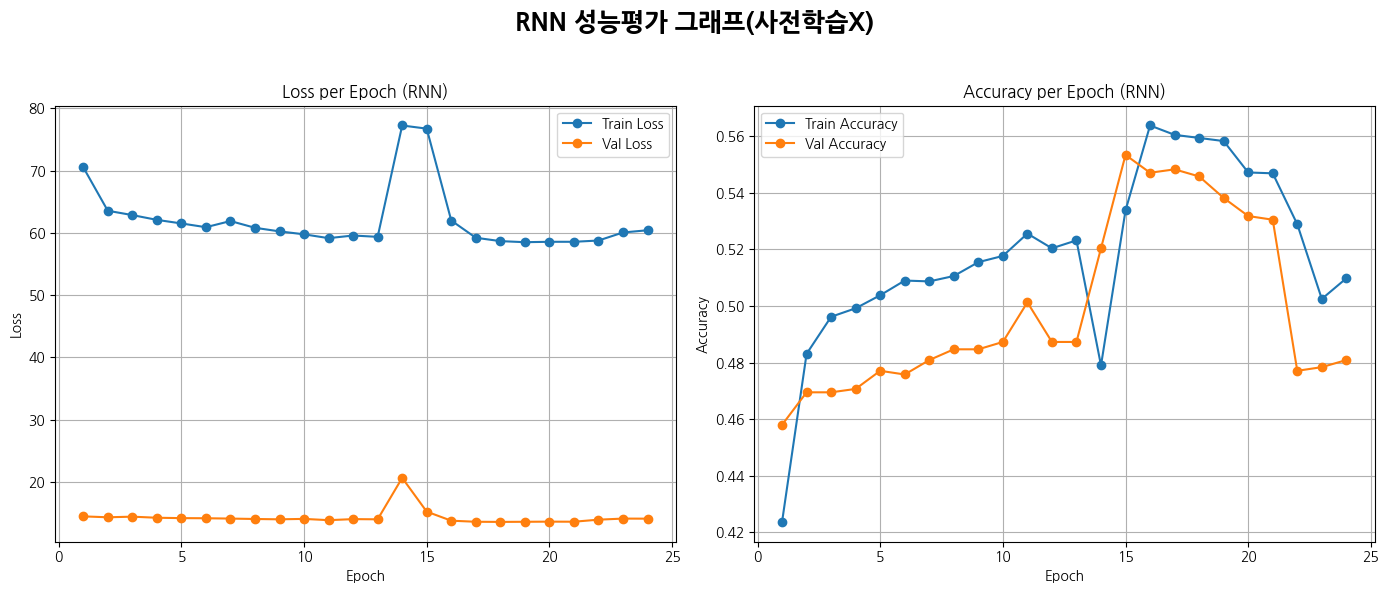

In [108]:
# 그래프 그리기
plt.figure(figsize=(14, 6))

# 전체 제목 추가
plt.suptitle('RNN 성능평가 그래프(사전학습X)', fontsize=18, fontweight='bold')

# 손실 함수 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch (RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch (RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("RNN_graph.png", dpi=150, transparent=True)
plt.show()

In [39]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        output, (hidden, _) = self.lstm(embedded)  # hidden: (num_layers, batch, hidden_dim)
        final_feature = hidden[-1]  # 마지막 레이어의 마지막 hidden state
        return self.fc(final_feature)

In [40]:
# 하이퍼파라미터
embedding_dim = 128
hidden_dim = 64
num_classes = len(set(label_ids))
vocab_size = len(vocab)

# 모델 초기화
device = torch.device("cpu")  # NCCL 에러 방지
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes).to(device)

# 학습 준비
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\KDP-35\anaconda3\envs\NLP\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [41]:
# DataLoader 준비
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

In [42]:
patience = 6  # 연속으로 val 손실이 좋아지지 않는 허용 횟수
epochs=30
trigger_times = 0
best_val_loss = float('inf')
best_model_path = "LSTM_best_model_dialect.pt"

for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증
    model.eval()
    total_val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"Epoch {epoch}/{epochs} )"
          f"Train Loss: {total_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {total_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 가장 좋은 검증 손실인 경우 저장
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 모델 저장됨: {best_model_path} (Val Loss: {best_val_loss:.4f})")
        trigger_times = 0  # 초기화
    else:
        trigger_times += 1
        print(f"⚠️ Early Stopping Trigger: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("🛑 손실률이 연속으로 개선되지 않아 조기 종료합니다.")
            break


Epoch 1/30 )Train Loss: 75.2445, Train Acc: 0.4128 | Val Loss: 14.4554, Val Acc: 0.4618
✅ 모델 저장됨: LSTM_best_model_dialect.pt (Val Loss: 14.4554)
Epoch 2/30 )Train Loss: 63.5586, Train Acc: 0.4872 | Val Loss: 14.3138, Val Acc: 0.4746
✅ 모델 저장됨: LSTM_best_model_dialect.pt (Val Loss: 14.3138)
Epoch 3/30 )Train Loss: 62.4662, Train Acc: 0.5000 | Val Loss: 14.0522, Val Acc: 0.5000
✅ 모델 저장됨: LSTM_best_model_dialect.pt (Val Loss: 14.0522)
Epoch 4/30 )Train Loss: 60.1592, Train Acc: 0.5300 | Val Loss: 12.7675, Val Acc: 0.5662
✅ 모델 저장됨: LSTM_best_model_dialect.pt (Val Loss: 12.7675)
Epoch 5/30 )Train Loss: 52.5068, Train Acc: 0.5960 | Val Loss: 11.7650, Val Acc: 0.6018
✅ 모델 저장됨: LSTM_best_model_dialect.pt (Val Loss: 11.7650)
Epoch 6/30 )Train Loss: 49.8354, Train Acc: 0.6371 | Val Loss: 11.2352, Val Acc: 0.6323
✅ 모델 저장됨: LSTM_best_model_dialect.pt (Val Loss: 11.2352)
Epoch 7/30 )Train Loss: 40.5616, Train Acc: 0.7399 | Val Loss: 10.5546, Val Acc: 0.6603
✅ 모델 저장됨: LSTM_best_model_dialect.pt (Val 

In [111]:
epochs_lstm = list(range(1, 16))  # 조기 종료된 15 epoch 기준

# 주어진 데이터
train_loss = [
    73.9569, 63.3622, 62.8689, 59.8088, 51.7907, 60.5590, 53.8776, 47.4179,
    42.4076, 38.1907, 36.5383, 33.8056, 30.7492, 28.3189, 26.7004
]
val_loss = [
    14.5043, 14.1463, 14.2468, 12.7911, 12.3719, 12.6320, 11.8246, 11.2640,
    10.4033, 11.0722, 10.4169, 10.6987, 11.0207, 10.9949, 11.0113
]
train_acc = [
    0.4624, 0.4940, 0.4869, 0.5360, 0.6221, 0.6006, 0.6191, 0.6652,
    0.7285, 0.7707, 0.7890, 0.8132, 0.8389, 0.8555, 0.8705
]
val_acc = [
    0.4682, 0.4835, 0.4733, 0.5865, 0.6132, 0.6043, 0.6081, 0.6323,
    0.6921, 0.6743, 0.6667, 0.7087, 0.6959, 0.7087, 0.7087
]


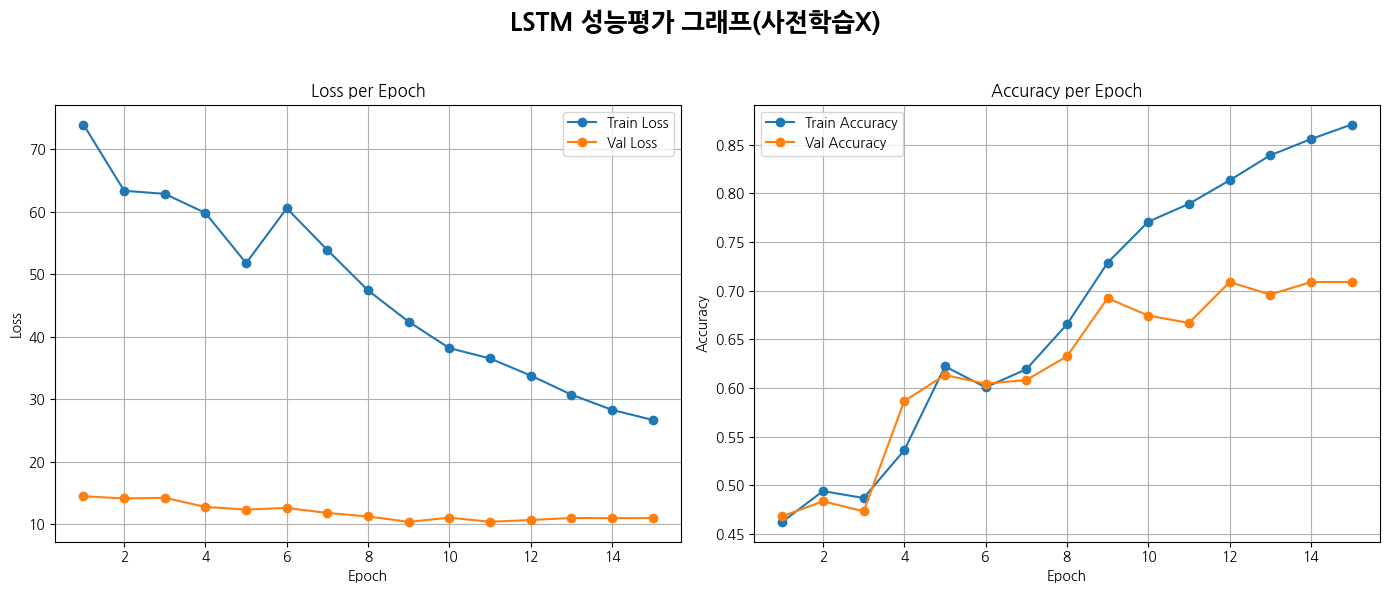

In [113]:
# 그래프 그리기
plt.figure(figsize=(14, 6))

# 전체 제목 추가
plt.suptitle('LSTM 성능평가 그래프(사전학습X)', fontsize=18, fontweight='bold')

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_lstm, train_loss, marker='o', label='Train Loss')
plt.plot(epochs_lstm, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_lstm, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs_lstm, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [45]:
from gensim.models import Word2Vec
from collections import Counter
import torch
import numpy as np

In [46]:
# 1. 텍스트 데이터 (전처리 포함)
data = data.dropna(subset=["CleanLine"])
texts = data["CleanLine"].astype(str).tolist()

In [47]:
# 2. 간단한 토크나이저
def tokenize(text):
    import re
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip().split()

In [48]:
# 3. 토큰화된 문장 리스트
tokenized_texts = [tokenize(text) for text in texts]
tokenized_texts

[['자막', '그들은', '놀라고', '무서움에', '사로잡혀서'],
 ['그들',
  '중',
  '한',
  '노인이',
  '지렁이를',
  '꿰며',
  '저편을',
  '응시하고',
  '있다',
  '심기가',
  '좋아',
  '보이질',
  '않는다',
  '중얼대고',
  '있다',
  '고약해',
  '보인다',
  '소리',
  '취기',
  '가득한',
  '남자들의',
  '커다란',
  '목소리와',
  '아낙네들의',
  '웃음',
  '소리'],
 ['짝을',
  '맞춰',
  '놀러',
  '온',
  '중년의',
  '남녀들이',
  '커다란',
  '양은솥에',
  '뭔가를',
  '끓여',
  '먹고',
  '있다'],
 ['그릇을',
  '노인의',
  '앞에',
  '내려놓은',
  '여자가',
  '겨드랑이에',
  '끼고',
  '온',
  '소주를',
  '종이컵에',
  '따른다',
  '여자를',
  '보니',
  '참하게',
  '생겼는데',
  '술에',
  '취해서인지',
  '옷',
  '매무새가',
  '흐트러졌다'],
 ['술을', '받아', '든', '노인이', '묘한', '눈길로', '여자를', '보더니', '음식을', '빤히', '쳐다본다'],
 ['여자못',
  '헌갑네',
  '얼릉',
  '드시어라',
  '닭',
  '닭',
  '쭉쭉',
  '얼큰혀',
  '얼큰',
  '노인의',
  '시선으로',
  '쭈그리고',
  '앉은',
  '여자의',
  '허벅지가',
  '보인다',
  '노인',
  '니들',
  '이',
  '개고기',
  '먹고',
  '떼씹하러',
  '갈',
  '생각이지'],
 ['구석에', '놓인', '테이블에', '김치와', '육회를', '안주로', '막걸리를', '마시는', '중년', '남자들'],
 ['천장에', '매달린', '고기를', '손질', '중인', '주인의', '얘기를', '듣고', '있다'],
 ['코가', '벌게진', '양복', '차림의',

In [49]:
# Word2Vec 모델 학습
embedding_dim = 100
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=embedding_dim,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # skip-gram
)

In [50]:
# 임베딩 행렬 생성
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)


In [51]:
class DNNClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim, num_classes):
        super(DNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
        self.fc1 = nn.Linear(embedding_tensor.shape[1] * 40, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)                    # (batch, seq, embed)
        x = x.view(x.size(0), -1)                # Flatten
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [52]:
# DataLoader 정의
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

In [53]:
# 모델, 손실 함수, 옵티마이저
hidden_dim = 64
num_classes = len(set(label_ids))
device = torch.device("cpu")

model = DNNClassifier(embedding_tensor, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# 학습 루프
epochs = 30
best_val_loss = float('inf')
patience = 6
trigger_times = 0
best_model_path = "best_model(Word2Vec)_dnn.pt"

for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증
    model.eval()
    total_val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"Epoch {epoch}/{epochs} | "
          f"Train Loss: {total_train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {total_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # EarlyStopping & 모델 저장
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved: {best_model_path}")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"⚠️ No improvement: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("🛑 Early stopping triggered.")
            break

Epoch 1/30 | Train Loss: 53.6209, Train Acc: 0.5971 | Val Loss: 11.5747, Val Acc: 0.6094
✅ Best model saved: best_model(Word2Vec)_dnn.pt
Epoch 2/30 | Train Loss: 46.8724, Train Acc: 0.6696 | Val Loss: 11.1108, Val Acc: 0.6718
✅ Best model saved: best_model(Word2Vec)_dnn.pt
Epoch 3/30 | Train Loss: 43.9511, Train Acc: 0.6982 | Val Loss: 11.0064, Val Acc: 0.6654
✅ Best model saved: best_model(Word2Vec)_dnn.pt
Epoch 4/30 | Train Loss: 38.9722, Train Acc: 0.7413 | Val Loss: 10.0791, Val Acc: 0.6959
✅ Best model saved: best_model(Word2Vec)_dnn.pt
Epoch 5/30 | Train Loss: 34.9932, Train Acc: 0.7644 | Val Loss: 10.0558, Val Acc: 0.6934
✅ Best model saved: best_model(Word2Vec)_dnn.pt
Epoch 6/30 | Train Loss: 28.6788, Train Acc: 0.8250 | Val Loss: 9.5705, Val Acc: 0.7226
✅ Best model saved: best_model(Word2Vec)_dnn.pt
Epoch 7/30 | Train Loss: 22.8204, Train Acc: 0.8580 | Val Loss: 9.5602, Val Acc: 0.7430
✅ Best model saved: best_model(Word2Vec)_dnn.pt
Epoch 8/30 | Train Loss: 17.3136, Train Acc

In [114]:
import matplotlib.pyplot as plt

# Epoch 수
epochs = list(range(1, 14))  # 13 epoch 진행

# 주어진 데이터
train_loss = [
    53.8146, 47.5082, 43.0424, 38.9822, 34.0875, 27.6554, 22.0850,
    17.5977, 14.4856, 11.1474, 9.1120, 7.7259, 5.9717
]
val_loss = [
    11.7921, 10.8627, 10.3545, 10.0114, 9.4456, 8.5739, 8.4490,
    8.4505, 8.5333, 8.9239, 9.0247, 9.6404, 9.9434
]
train_acc = [
    0.6020, 0.6644, 0.6998, 0.7372, 0.7814, 0.8190, 0.8615,
    0.8967, 0.9158, 0.9397, 0.9586, 0.9629, 0.9725
]
val_acc = [
    0.6120, 0.6628, 0.6921, 0.6959, 0.7087, 0.7570, 0.7621,
    0.7608, 0.7774, 0.7672, 0.7684, 0.7608, 0.7595
]


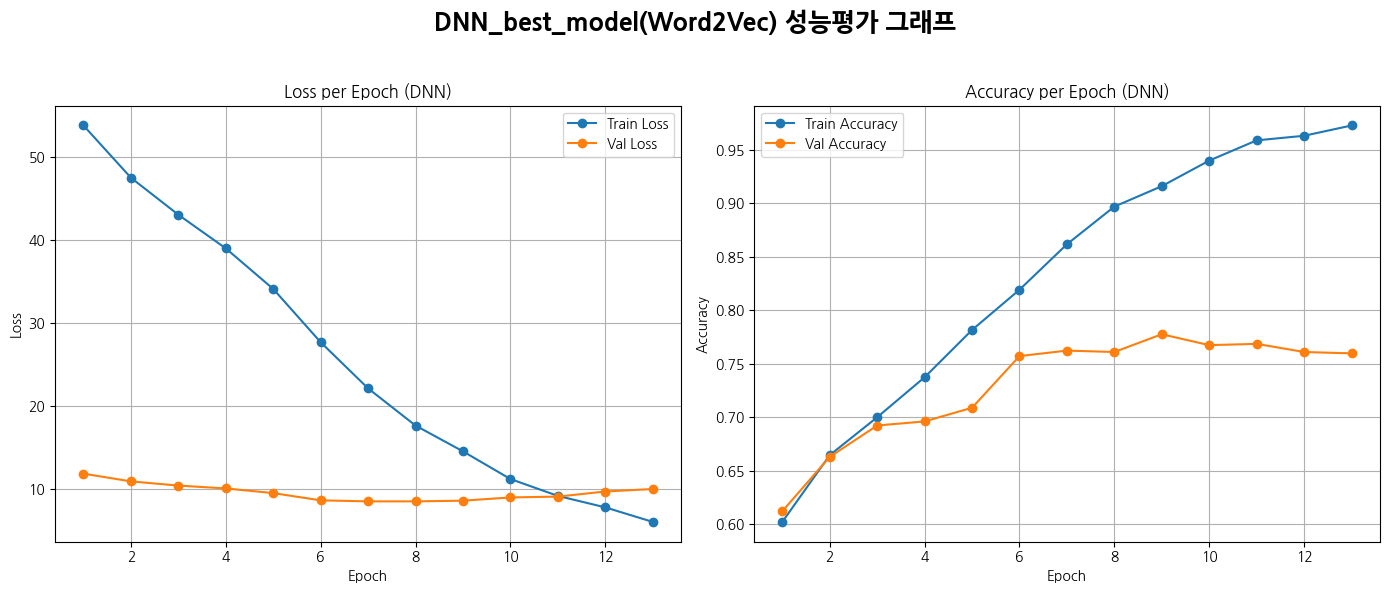

In [115]:
# 그래프 그리기
plt.figure(figsize=(14, 6))
plt.suptitle('DNN_best_model(Word2Vec) 성능평가 그래프', fontsize=18, fontweight='bold')

# 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch (DNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch (DNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("DNN_best_model_word2vec_graph.png", dpi=150, transparent=True)
plt.show()

In [57]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim, num_classes, num_layers=1, dropout=0.3):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
        self.rnn = nn.RNN(
            input_size=embedding_tensor.shape[1],
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        output, hidden = self.rnn(embedded)  # hidden: (num_layers, batch, hidden_dim)
        final_feature = hidden[-1]  # 마지막 층의 hidden state
        return self.fc(final_feature)

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNNClassifier(
    embedding_tensor=embedding_tensor,
    hidden_dim=64,
    num_classes=len(set(label_ids))
).to(device)

c:\Users\KDP-35\anaconda3\envs\NLP\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [60]:
# 학습 루프
epochs = 30
best_val_loss = float('inf')
patience = 6
trigger_times = 0
best_model_path = "best_model(Word2Vec)_rnn.pt"

for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증
    model.eval()
    total_val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"Epoch {epoch}/{epochs} | "
          f"Train Loss: {total_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {total_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # EarlyStopping & 모델 저장
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved: {best_model_path}")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"⚠️ No improvement: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("🛑 Early stopping triggered.")
            break

Epoch 1/30 | Train Loss: 67.0199, Train Acc: 0.4727 | Val Loss: 14.3247, Val Acc: 0.4707
✅ Best model saved: best_model(Word2Vec)_rnn.pt
Epoch 2/30 | Train Loss: 62.8485, Train Acc: 0.4883 | Val Loss: 14.3060, Val Acc: 0.4720
✅ Best model saved: best_model(Word2Vec)_rnn.pt
Epoch 3/30 | Train Loss: 62.4904, Train Acc: 0.4894 | Val Loss: 14.2647, Val Acc: 0.4784
✅ Best model saved: best_model(Word2Vec)_rnn.pt
Epoch 4/30 | Train Loss: 62.2029, Train Acc: 0.4943 | Val Loss: 14.3276, Val Acc: 0.4822
⚠️ No improvement: 1/6
Epoch 5/30 | Train Loss: 61.1628, Train Acc: 0.5022 | Val Loss: 14.1061, Val Acc: 0.4796
✅ Best model saved: best_model(Word2Vec)_rnn.pt
Epoch 6/30 | Train Loss: 60.7531, Train Acc: 0.5131 | Val Loss: 13.9564, Val Acc: 0.4898
✅ Best model saved: best_model(Word2Vec)_rnn.pt
Epoch 7/30 | Train Loss: 62.0721, Train Acc: 0.5354 | Val Loss: 14.0928, Val Acc: 0.4860
⚠️ No improvement: 1/6
Epoch 8/30 | Train Loss: 60.8046, Train Acc: 0.5090 | Val Loss: 13.9610, Val Acc: 0.4860
⚠️

In [121]:
import matplotlib.pyplot as plt

# 에폭 수 (1~19)
epochs = list(range(1, len(train_loss) + 1))

# 로그에서 추출한 값
train_loss = [
    67.0199, 62.8485, 62.4904, 62.2029, 61.1628, 60.7531, 62.0721, 60.8046,
    57.9158, 49.2891, 46.9563, 46.1021, 45.7651, 44.1500, 43.3052, 44.4526
]
val_loss = [
    14.3247, 14.3060, 14.2647, 14.3276, 14.1061, 13.9564, 14.0928, 13.9610,
    12.7871, 11.7882, 12.1454, 12.1641, 11.9142, 11.7891, 11.8506, 13.4310
]
train_acc = [
    0.4727, 0.4883, 0.4894, 0.4943, 0.5022, 0.5131, 0.5354, 0.5090,
    0.5665, 0.6797, 0.6897, 0.7026, 0.7042, 0.7118, 0.7214, 0.7146
]
val_acc = [
    0.4707, 0.4720, 0.4784, 0.4822, 0.4796, 0.4898, 0.4860, 0.4860,
    0.6031, 0.6463, 0.6450, 0.6438, 0.6489, 0.6539, 0.6514, 0.6081
]

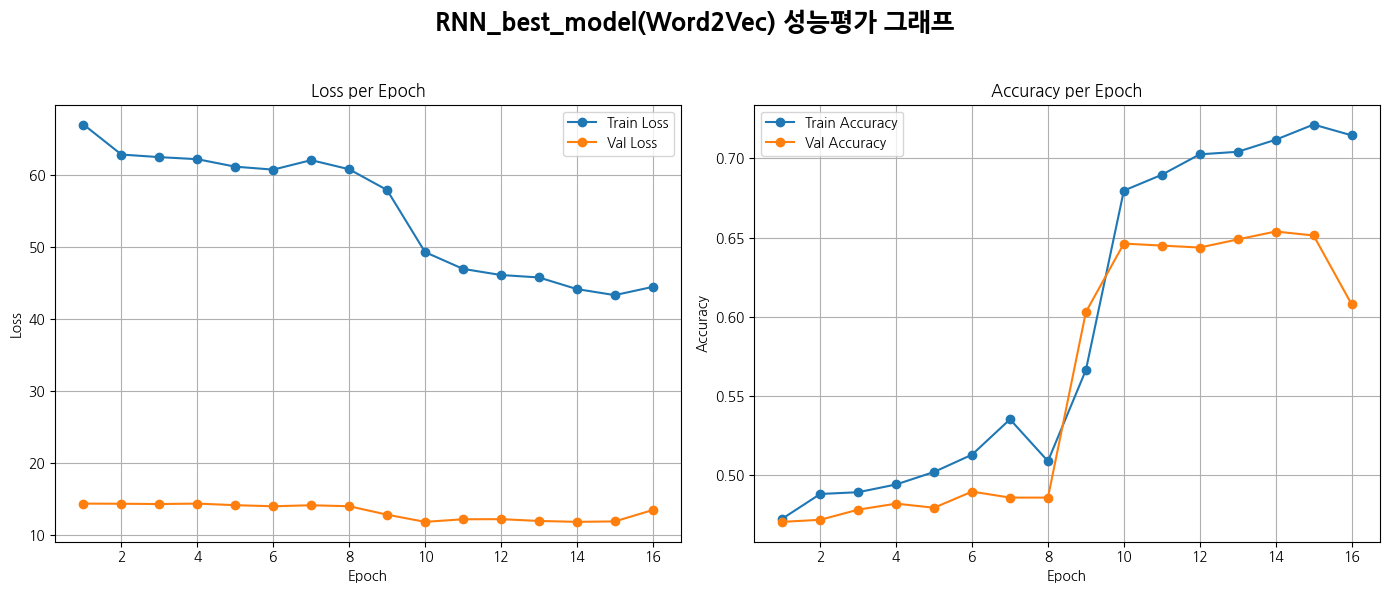

In [122]:
# 그래프 그리기
plt.figure(figsize=(14, 6))
plt.suptitle('RNN_best_model(Word2Vec) 성능평가 그래프', fontsize=18, fontweight='bold')

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [63]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim, num_classes, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
        self.lstm = nn.LSTM(
            input_size=embedding_tensor.shape[1],
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False  # 필요시 True도 가능
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)                    # (batch, seq_len, embed_dim)
        output, (hidden, _) = self.lstm(embedded)       # hidden: (num_layers, batch, hidden_dim)
        final_feature = hidden[-1]                      # 마지막 레이어의 hidden state 사용
        return self.fc(final_feature)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMClassifier(
    embedding_tensor=embedding_tensor,
    hidden_dim=64,
    num_classes=len(set(label_ids)),
    num_layers=1,
    dropout=0.3
).to(device)

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
# 학습 루프
epochs = 30
best_val_loss = float('inf')
patience = 6
trigger_times = 0
best_model_path = "best_model(Word2Vec)_lstm.pt"

for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증
    model.eval()
    total_val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"Epoch {epoch}/{epochs} | "
          f"Train Loss: {total_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {total_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # EarlyStopping & 모델 저장
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved: {best_model_path}")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"⚠️ No improvement: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("🛑 Early stopping triggered.")
            break

Epoch 1/30 | Train Loss: 68.7056, Train Acc: 0.4741 | Val Loss: 14.2251, Val Acc: 0.4720
✅ Best model saved: best_model(Word2Vec)_lstm.pt
Epoch 2/30 | Train Loss: 50.9989, Train Acc: 0.6150 | Val Loss: 10.2991, Val Acc: 0.6667
✅ Best model saved: best_model(Word2Vec)_lstm.pt
Epoch 3/30 | Train Loss: 31.8532, Train Acc: 0.7789 | Val Loss: 9.2618, Val Acc: 0.7684
✅ Best model saved: best_model(Word2Vec)_lstm.pt
Epoch 4/30 | Train Loss: 22.3161, Train Acc: 0.8803 | Val Loss: 9.6560, Val Acc: 0.7684
⚠️ No improvement: 1/6
Epoch 5/30 | Train Loss: 15.7141, Train Acc: 0.9305 | Val Loss: 10.4849, Val Acc: 0.7659
⚠️ No improvement: 2/6
Epoch 6/30 | Train Loss: 12.6284, Train Acc: 0.9397 | Val Loss: 11.5451, Val Acc: 0.7634
⚠️ No improvement: 3/6
Epoch 7/30 | Train Loss: 14.2936, Train Acc: 0.9387 | Val Loss: 11.0041, Val Acc: 0.7595
⚠️ No improvement: 4/6
Epoch 8/30 | Train Loss: 12.6896, Train Acc: 0.9474 | Val Loss: 11.5609, Val Acc: 0.7786
⚠️ No improvement: 5/6
Epoch 9/30 | Train Loss: 10.

In [123]:
import matplotlib.pyplot as plt

# 조기 종료까지 총 9 epoch 진행
epochs = list(range(1, 10))

# 로그에서 추출한 값
train_loss = [68.7056, 50.9989, 31.8532, 22.3161, 15.7141, 12.6284, 14.2936, 12.6896, 10.8013]
val_loss   = [14.2251, 10.2991, 9.2618, 9.6560, 10.4849, 11.5451, 11.0041, 11.5609, 10.7376]
train_acc  = [0.4741, 0.6150, 0.7789, 0.8803, 0.9305, 0.9397, 0.9387, 0.9474, 0.9542]
val_acc    = [0.4720, 0.6667, 0.7684, 0.7684, 0.7659, 0.7634, 0.7595, 0.7786, 0.7850]

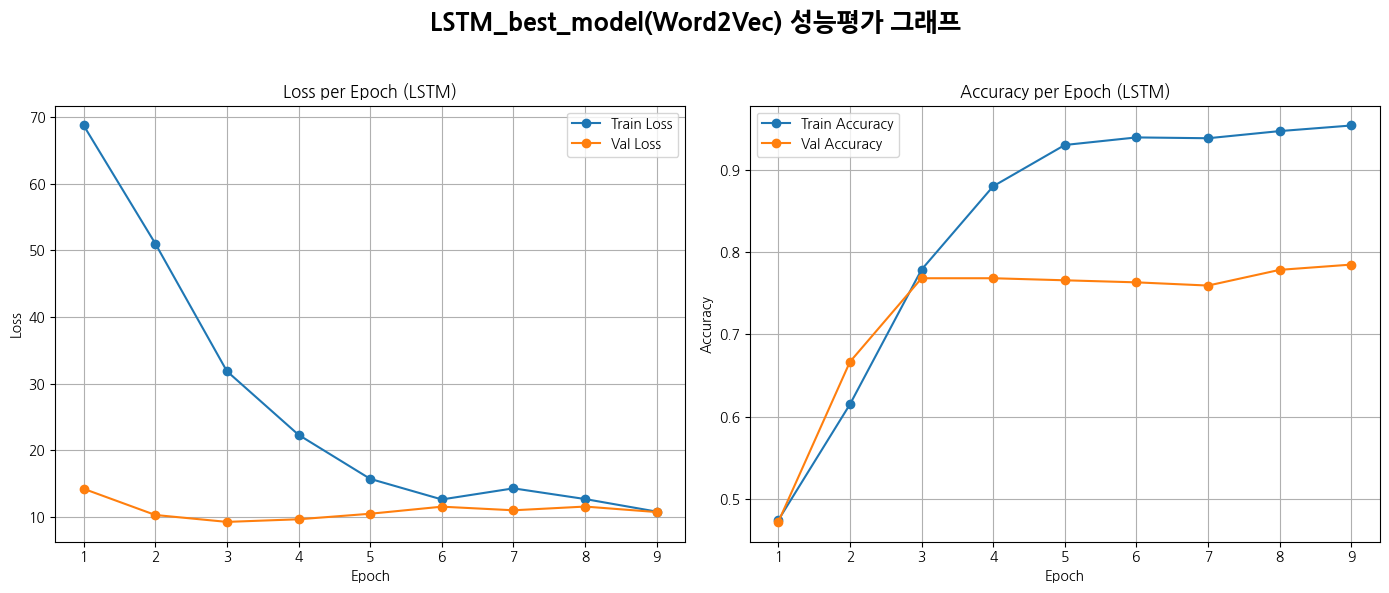

In [124]:
# 그래프 그리기
plt.figure(figsize=(14, 6))
plt.suptitle('LSTM_best_model(Word2Vec) 성능평가 그래프', fontsize=18, fontweight='bold')

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("LSTM_best_model_word2vec_graph.png", dpi=150, transparent=True)
plt.show()

In [69]:
from gensim.models import FastText

In [70]:
tokenized_texts = [tokenize(text) for text in texts]
tokenized_texts

[['자막', '그들은', '놀라고', '무서움에', '사로잡혀서'],
 ['그들',
  '중',
  '한',
  '노인이',
  '지렁이를',
  '꿰며',
  '저편을',
  '응시하고',
  '있다',
  '심기가',
  '좋아',
  '보이질',
  '않는다',
  '중얼대고',
  '있다',
  '고약해',
  '보인다',
  '소리',
  '취기',
  '가득한',
  '남자들의',
  '커다란',
  '목소리와',
  '아낙네들의',
  '웃음',
  '소리'],
 ['짝을',
  '맞춰',
  '놀러',
  '온',
  '중년의',
  '남녀들이',
  '커다란',
  '양은솥에',
  '뭔가를',
  '끓여',
  '먹고',
  '있다'],
 ['그릇을',
  '노인의',
  '앞에',
  '내려놓은',
  '여자가',
  '겨드랑이에',
  '끼고',
  '온',
  '소주를',
  '종이컵에',
  '따른다',
  '여자를',
  '보니',
  '참하게',
  '생겼는데',
  '술에',
  '취해서인지',
  '옷',
  '매무새가',
  '흐트러졌다'],
 ['술을', '받아', '든', '노인이', '묘한', '눈길로', '여자를', '보더니', '음식을', '빤히', '쳐다본다'],
 ['여자못',
  '헌갑네',
  '얼릉',
  '드시어라',
  '닭',
  '닭',
  '쭉쭉',
  '얼큰혀',
  '얼큰',
  '노인의',
  '시선으로',
  '쭈그리고',
  '앉은',
  '여자의',
  '허벅지가',
  '보인다',
  '노인',
  '니들',
  '이',
  '개고기',
  '먹고',
  '떼씹하러',
  '갈',
  '생각이지'],
 ['구석에', '놓인', '테이블에', '김치와', '육회를', '안주로', '막걸리를', '마시는', '중년', '남자들'],
 ['천장에', '매달린', '고기를', '손질', '중인', '주인의', '얘기를', '듣고', '있다'],
 ['코가', '벌게진', '양복', '차림의',

In [71]:
model = FastText(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # skip-gram
)

In [72]:
# 단어 집합에 맞게 임베딩 매트릭스 생성
embedding_matrix = np.zeros((len(vocab), 100))

for word, idx in vocab.items():
    if word in model.wv:
        embedding_matrix[idx] = model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(100,))

embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

In [73]:
class DNNClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim, num_classes):
        super(DNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
        self.fc1 = nn.Linear(embedding_tensor.shape[1] * 40, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [74]:
model = DNNClassifier(embedding_tensor, hidden_dim=64, num_classes=len(set(label_ids))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
# 학습 데이터셋 준비
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

In [76]:
# 학습 루프
epochs = 30
best_val_loss = float('inf')
patience = 6
trigger = 0
best_model_path = "best_fasttext_dnn.pt"

In [77]:
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_train += (output.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증
    model.eval()
    val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
            correct_val += (output.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping 조건 확인
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 모델 저장: {best_model_path}")
        trigger = 0
    else:
        trigger += 1
        print(f"⚠️ 개선 없음 {trigger}/{patience}")
        if trigger >= patience:
            print("🛑 Early stopping 발생")
            break

[Epoch 1] Train Loss: 60.0779, Acc: 0.5431 | Val Loss: 11.8496, Acc: 0.6209
✅ 모델 저장: best_fasttext_dnn.pt
[Epoch 2] Train Loss: 46.7121, Acc: 0.6674 | Val Loss: 10.5322, Acc: 0.6679
✅ 모델 저장: best_fasttext_dnn.pt
[Epoch 3] Train Loss: 34.6315, Acc: 0.7868 | Val Loss: 9.0367, Acc: 0.7494
✅ 모델 저장: best_fasttext_dnn.pt
[Epoch 4] Train Loss: 23.4380, Acc: 0.8667 | Val Loss: 8.2903, Acc: 0.7761
✅ 모델 저장: best_fasttext_dnn.pt
[Epoch 5] Train Loss: 16.2688, Acc: 0.9065 | Val Loss: 8.1593, Acc: 0.7863
✅ 모델 저장: best_fasttext_dnn.pt
[Epoch 6] Train Loss: 10.9575, Acc: 0.9441 | Val Loss: 8.8447, Acc: 0.7735
⚠️ 개선 없음 1/6
[Epoch 7] Train Loss: 7.7737, Acc: 0.9651 | Val Loss: 9.0544, Acc: 0.7837
⚠️ 개선 없음 2/6
[Epoch 8] Train Loss: 5.6595, Acc: 0.9730 | Val Loss: 9.2216, Acc: 0.7672
⚠️ 개선 없음 3/6
[Epoch 9] Train Loss: 4.2287, Acc: 0.9817 | Val Loss: 10.1371, Acc: 0.7774
⚠️ 개선 없음 4/6
[Epoch 10] Train Loss: 3.3345, Acc: 0.9856 | Val Loss: 9.9458, Acc: 0.7748
⚠️ 개선 없음 5/6
[Epoch 11] Train Loss: 2.7882, Acc:

In [125]:
import matplotlib.pyplot as plt

# 조기 종료까지 11 epoch
epochs = list(range(1, 12))

# 로그에서 추출한 값
train_loss = [
    60.0779, 46.7121, 34.6315, 23.4380, 16.2688, 10.9575,
    7.7737, 5.6595, 4.2287, 3.3345, 2.7882
]
val_loss = [
    11.8496, 10.5322, 9.0367, 8.2903, 8.1593, 8.8447,
    9.0544, 9.2216, 10.1371, 9.9458, 10.8722
]
train_acc = [
    0.5431, 0.6674, 0.7868, 0.8667, 0.9065, 0.9441,
    0.9651, 0.9730, 0.9817, 0.9856, 0.9888
]
val_acc = [
    0.6209, 0.6679, 0.7494, 0.7761, 0.7863, 0.7735,
    0.7837, 0.7672, 0.7774, 0.7748, 0.7824
]


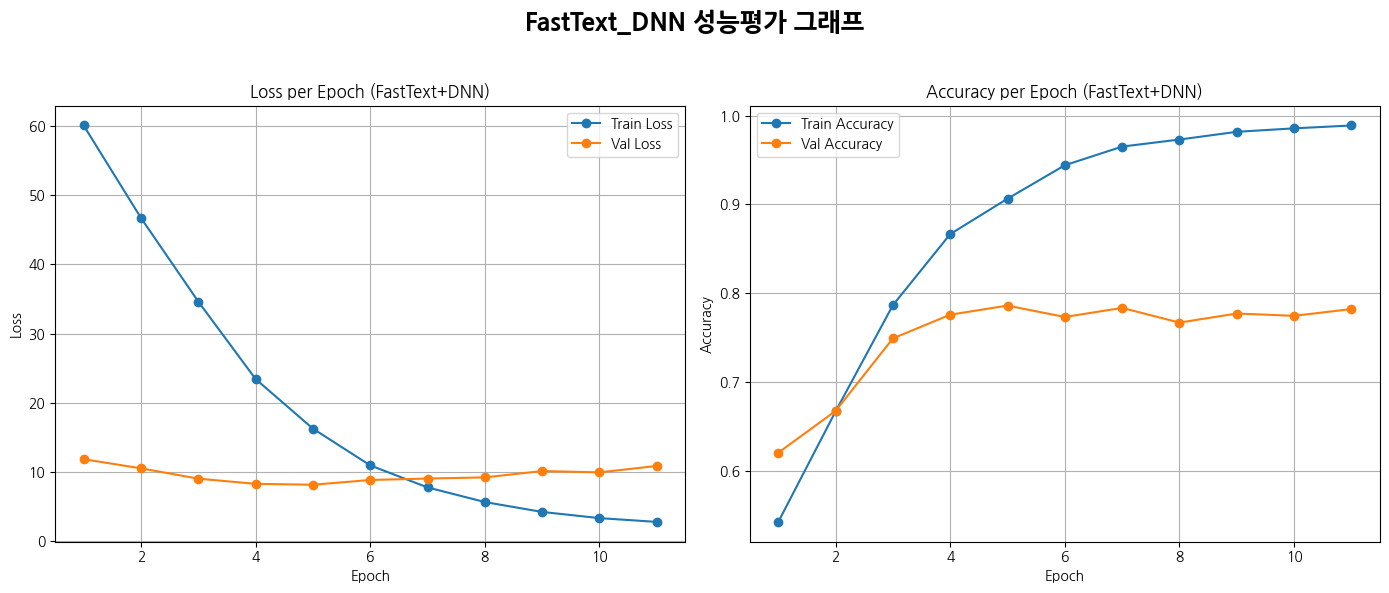

In [126]:
# 그래프 그리기
plt.figure(figsize=(14, 6))
plt.suptitle('FastText_DNN 성능평가 그래프', fontsize=18, fontweight='bold')

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch (FastText+DNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch (FastText+DNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("FastText_DNN_graph.png", dpi=150, transparent=True)
plt.show()

In [80]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim, num_classes, num_layers=1, dropout=0.3):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
        self.rnn = nn.RNN(
            input_size=embedding_tensor.shape[1],
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embed_dim)
        _, hidden = self.rnn(x)  # hidden: (num_layers, batch, hidden_dim)
        return self.fc(hidden[-1])  # 마지막 레이어 hidden state 사용


In [81]:
# 학습 하이퍼파라미터
hidden_dim = 64
num_classes = len(set(label_ids))
epochs = 30
patience = 6
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
# 모델 초기화
model = RNNClassifier(embedding_tensor, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [83]:
# DataLoader 설정
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)


In [84]:
# 학습 루프
best_val_loss = float('inf')
trigger = 0
best_model_path = "best_fasttext_rnn.pt"

for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증 루프
    model.eval()
    total_val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"[Epoch {epoch}] Train Loss: {total_train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {total_val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping 조건
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 모델 저장됨: {best_model_path}")
        trigger = 0
    else:
        trigger += 1
        print(f"⚠️ 개선 없음: {trigger}/{patience}")
        if trigger >= patience:
            print("🛑 조기 종료 발생")
            break

[Epoch 1] Train Loss: 69.5399, Acc: 0.4338 | Val Loss: 14.3673, Acc: 0.4733
✅ 모델 저장됨: best_fasttext_rnn.pt
[Epoch 2] Train Loss: 63.1522, Acc: 0.4779 | Val Loss: 14.7302, Acc: 0.4733
⚠️ 개선 없음: 1/6
[Epoch 3] Train Loss: 63.0692, Acc: 0.4875 | Val Loss: 14.2720, Acc: 0.4707
✅ 모델 저장됨: best_fasttext_rnn.pt
[Epoch 4] Train Loss: 62.3331, Acc: 0.4896 | Val Loss: 14.1934, Acc: 0.4720
✅ 모델 저장됨: best_fasttext_rnn.pt
[Epoch 5] Train Loss: 61.7432, Acc: 0.4975 | Val Loss: 14.2799, Acc: 0.4733
⚠️ 개선 없음: 1/6
[Epoch 6] Train Loss: 61.2866, Acc: 0.5098 | Val Loss: 14.5201, Acc: 0.4682
⚠️ 개선 없음: 2/6
[Epoch 7] Train Loss: 63.7610, Acc: 0.4782 | Val Loss: 14.4453, Acc: 0.4682
⚠️ 개선 없음: 3/6
[Epoch 8] Train Loss: 63.4216, Acc: 0.4902 | Val Loss: 14.3306, Acc: 0.4746
⚠️ 개선 없음: 4/6
[Epoch 9] Train Loss: 62.6114, Acc: 0.4951 | Val Loss: 14.3572, Acc: 0.4733
⚠️ 개선 없음: 5/6
[Epoch 10] Train Loss: 62.0389, Acc: 0.4978 | Val Loss: 14.2843, Acc: 0.4720
⚠️ 개선 없음: 6/6
🛑 조기 종료 발생


In [127]:
import matplotlib.pyplot as plt

# 에폭 수 (1~20)
epochs = list(range(1, 11))

# 로그에서 추출한 값
train_loss = [
    69.5399, 63.1522, 63.0692, 62.3331, 61.7432,
    61.2866, 63.7610, 63.4216, 62.6114, 62.0389
]
val_loss = [
    14.3673, 14.7302, 14.2720, 14.1934, 14.2799,
    14.5201, 14.4453, 14.3306, 14.3572, 14.2843
]
train_acc = [
    0.4338, 0.4779, 0.4875, 0.4896, 0.4975,
    0.5098, 0.4782, 0.4902, 0.4951, 0.4978
]
val_acc = [
    0.4733, 0.4733, 0.4707, 0.4720, 0.4733,
    0.4682, 0.4682, 0.4746, 0.4733, 0.4720
]

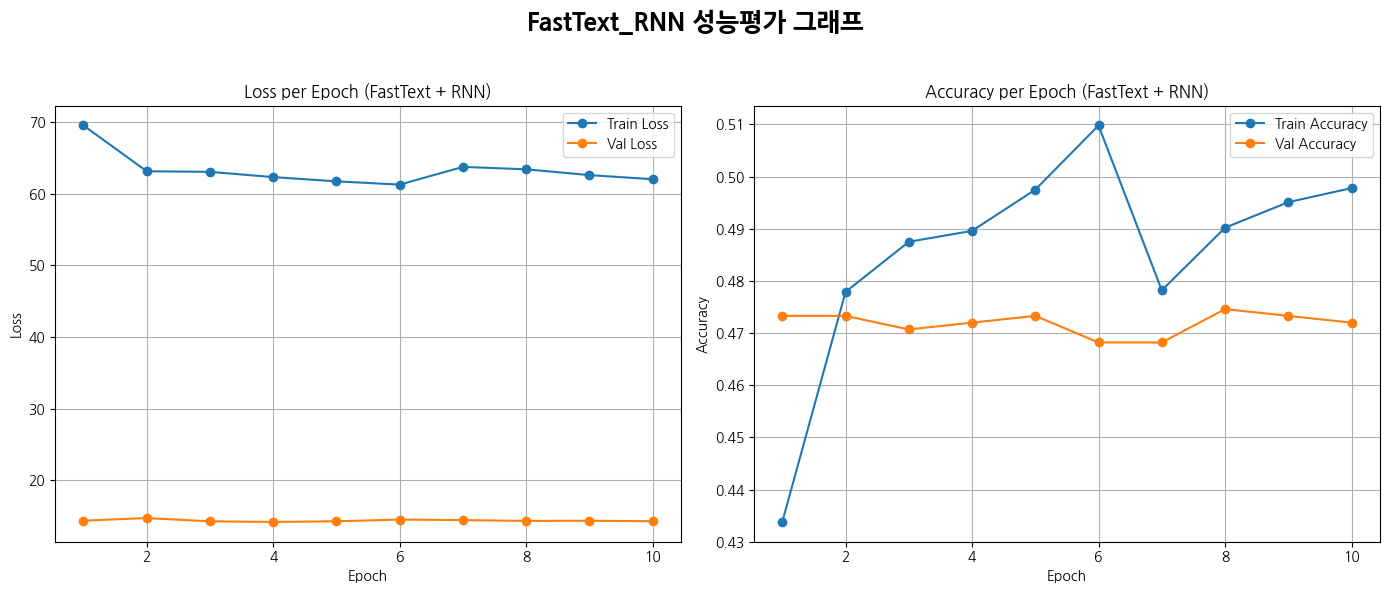

In [128]:
# 그래프 그리기
plt.figure(figsize=(14, 6))
plt.suptitle('FastText_RNN 성능평가 그래프', fontsize=18, fontweight='bold')

# 손실 함수 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch (FastText + RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch (FastText + RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("FastText_RNN_graph.png", dpi=150, transparent=True)
plt.show()

In [87]:
# 하이퍼파라미터
hidden_dim = 64
num_classes = len(set(label_ids))
epochs = 30
patience = 6
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = LSTMClassifier(embedding_tensor, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# DataLoader 구성
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# 학습 루프 시작
best_val_loss = float('inf')
trigger = 0
best_model_path = "best_fasttext_lstm.pt"

for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # 검증
    model.eval()
    total_val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    print(f"[Epoch {epoch}] Train Loss: {total_train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {total_val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early Stopping 체크
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best 모델 저장됨: {best_model_path}")
        trigger = 0
    else:
        trigger += 1
        print(f"⚠️ 개선 없음: {trigger}/{patience}")
        if trigger >= patience:
            print("🛑 Early Stopping 발생")
            break

[Epoch 1] Train Loss: 71.5460, Acc: 0.4605 | Val Loss: 14.1782, Acc: 0.4796
✅ Best 모델 저장됨: best_fasttext_lstm.pt
[Epoch 2] Train Loss: 51.4471, Acc: 0.6131 | Val Loss: 10.7776, Acc: 0.6539
✅ Best 모델 저장됨: best_fasttext_lstm.pt
[Epoch 3] Train Loss: 37.0195, Acc: 0.7246 | Val Loss: 10.7513, Acc: 0.6692
✅ Best 모델 저장됨: best_fasttext_lstm.pt
[Epoch 4] Train Loss: 31.9052, Acc: 0.8258 | Val Loss: 9.5924, Acc: 0.7290
✅ Best 모델 저장됨: best_fasttext_lstm.pt
[Epoch 5] Train Loss: 26.3703, Acc: 0.8686 | Val Loss: 9.4566, Acc: 0.7532
✅ Best 모델 저장됨: best_fasttext_lstm.pt
[Epoch 6] Train Loss: 16.8968, Acc: 0.9278 | Val Loss: 9.9692, Acc: 0.7672
⚠️ 개선 없음: 1/6
[Epoch 7] Train Loss: 20.1739, Acc: 0.9076 | Val Loss: 11.2428, Acc: 0.7150
⚠️ 개선 없음: 2/6
[Epoch 8] Train Loss: 15.7362, Acc: 0.9419 | Val Loss: 11.8972, Acc: 0.7557
⚠️ 개선 없음: 3/6
[Epoch 9] Train Loss: 10.9346, Acc: 0.9591 | Val Loss: 11.4751, Acc: 0.7646
⚠️ 개선 없음: 4/6
[Epoch 10] Train Loss: 9.6807, Acc: 0.9640 | Val Loss: 10.9517, Acc: 0.7621
⚠️

In [131]:
import matplotlib.pyplot as plt

# Epoch 수
epochs = list(range(1, 12))  # 1~11까지

# 로그에서 추출한 값들
train_loss = [
    71.5460, 51.4471, 37.0195, 31.9052, 26.3703,
    16.8968, 20.1739, 15.7362, 10.9346, 9.6807, 9.9056
]
val_loss = [
    14.1782, 10.7776, 10.7513, 9.5924, 9.4566,
    9.9692, 11.2428, 11.8972, 11.4751, 10.9517, 12.5837
]
train_acc = [
    0.4605, 0.6131, 0.7246, 0.8258, 0.8686,
    0.9278, 0.9076, 0.9419, 0.9591, 0.9640, 0.9654
]
val_acc = [
    0.4796, 0.6539, 0.6692, 0.7290, 0.7532,
    0.7672, 0.7150, 0.7557, 0.7646, 0.7621, 0.7634
]


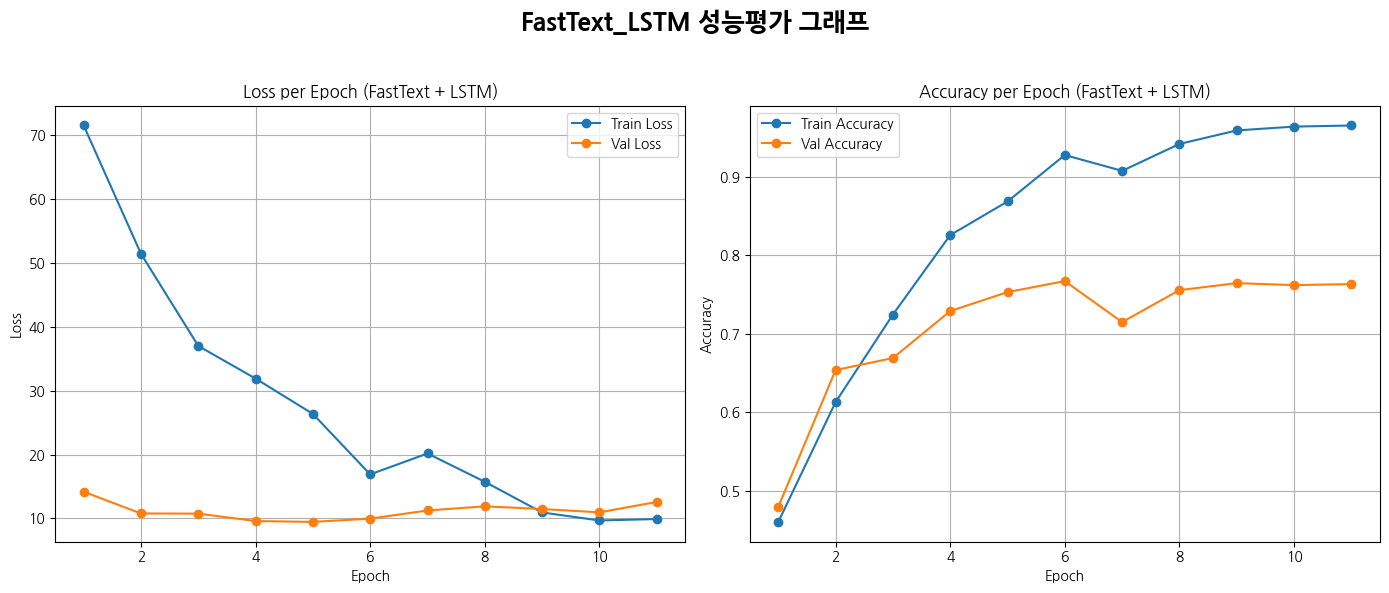

In [132]:
# 그래프 그리기
plt.figure(figsize=(14, 6))
plt.suptitle('FastText_LSTM 성능평가 그래프', fontsize=18, fontweight='bold')

# 손실 함수 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title('Loss per Epoch (FastText + LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title('Accuracy per Epoch (FastText + LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("FastText_LSTM_graph.png", dpi=150, transparent=True)
plt.show()

In [157]:
# 예측에 필요한 클래스 정의 (모델 구조와 맞게!)
class DNNClassifier(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128, output_dim=8):
        super(DNNClassifier, self).__init__()
        self.embedding = nn.Identity()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 텍스트 전처리 → 벡터 평균화
def preprocess_text(text, vocab, embedding_model):
    tokens = text.split()
    vecs = []
    for token in tokens:
        idx = vocab.get(token)
        if idx is not None:
            vecs.append(embedding_model[idx])
    if not vecs:
        vecs.append(torch.zeros(300))
    return torch.mean(torch.stack(vecs), dim=0).unsqueeze(0)

# 예측 함수
def predict_one(text, model, vocab, embedding_model, label_mapping):
    model.eval()
    input_tensor = preprocess_text(text, vocab, embedding_model)
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    return label_mapping[pred]

In [148]:
import torch
import torch.nn as nn

class DNNClassifier(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128, output_dim=8):
        super(DNNClassifier, self).__init__()
        self.embedding = nn.Identity()  # Word2Vec 벡터 직접 입력 시 placeholder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [153]:
def preprocess_text(text, vocab, embedding_model):
    tokens = text.split()
    vecs = []
    for token in tokens:
        idx = vocab.get(token)
        if idx is not None:
            vecs.append(embedding_model[idx])
    if not vecs:
        vecs.append(torch.zeros(300))
    return torch.mean(torch.stack(vecs), dim=0).unsqueeze(0)  # [1, 300]

def predict_one(text, model, vocab, embedding_model, label_mapping):
    model.eval()
    input_tensor = preprocess_text(text, vocab, embedding_model)
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    return label_mapping[pred]

In [154]:
# 라벨 매핑 예시 (실제 클래스 수에 따라 수정)
label_mapping = {
    0: "서울", 1: "경기", 2: "강원", 3: "충청", 4: "경상", 5: "전라", 6: "제주", 7: "기타"
}

# vocab 및 임베딩 모델 (Word2Vec) 준비된 경우
# 예: vocab = {'너': 0, '이': 1, ...}, embedding_model = torch.FloatTensor([...])
# 여기서는 가정합니다: vocab, embedding_model 정의되어 있음

# 모델 초기화 및 가중치 로딩
model = DNNClassifier(input_dim=300, hidden_dim=128, output_dim=len(label_mapping))
model_path = r"C:\Users\KDP-35\Desktop\KDT7\NLP\Miniproject\best_model(Word2Vec)_dnn.pt"
model.load_state_dict(torch.load(model_path, map_location='cpu'))

RuntimeError: Error(s) in loading state_dict for DNNClassifier:
	Unexpected key(s) in state_dict: "embedding.weight". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([64, 4000]) from checkpoint, the shape in current model is torch.Size([128, 300]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([5, 64]) from checkpoint, the shape in current model is torch.Size([8, 128]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([8]).

In [138]:
# 예측 실행
sample_text = "너 뭐하냐 진짜 왜 그래?"
predicted = predict_one(sample_text, model, vocab, embedding_model, label_mapping)
print(f"🗣️ 예측된 방언: {predicted}")

NameError: name 'embedding_model' is not defined

In [135]:
text = "기왕 이렇게 된 거 재판은 잘해야 된다"  # 예: 경상도 (우리 형 중호)
model_path = "best_model(Word2Vec)_lstm.pt"

predicted = predict_dialect(
    text=text,
    model_path=model_path,
    vocab=vocab,
    label_mapping=label_mapping,
    model_class=LSTMClassifier,  # LSTMClassifier, CNNClassifier 등도 가능
    embedding_tensor=embedding_tensor
)

print(f"🗣️ 예측된 방언: {predicted}")

AttributeError: 'Tensor' object has no attribute 'embedding_dim'

In [ ]:
text = "어쩔려구?"  # 예: 전라도 (꽃피는 봄이오면)
model_path = "best_model(Word2Vec)_lstm.pt"

predicted = predict_dialect(
    text=text,
    model_path=model_path,
    vocab=vocab,
    label_mapping=label_mapping,
    model_class=LSTMClassifier,  # LSTMClassifier, CNNClassifier 등도 가능
    embedding_tensor=embedding_tensor
)

print(f"🗣️ 예측된 방언: {predicted}")

In [ ]:
text = "해당께"  # 예: 전라도 
model_path = "best_model(Word2Vec)_lstm.pt"

predicted = predict_dialect(
    text=text,
    model_path=model_path,
    vocab=vocab,
    label_mapping=label_mapping,
    model_class=LSTMClassifier,  # LSTMClassifier, CNNClassifier 등도 가능
    embedding_tensor=embedding_tensor
)

print(f"🗣️ 예측된 방언: {predicted}")

In [ ]:
text = "워매"  # 예: 전라도 
model_path = "best_model(Word2Vec)_lstm.pt"

predicted = predict_dialect(
    text=text,
    model_path=model_path,
    vocab=vocab,
    label_mapping=label_mapping,
    model_class=LSTMClassifier,  # LSTMClassifier, CNNClassifier 등도 가능
    embedding_tensor=embedding_tensor
)

print(f"🗣️ 예측된 방언: {predicted}")